In [1]:
%run common_init.py

Start import
calculating effective efficiency for Xe detector done
calculating effective efficiency for Ge detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Xe_migd detector done
calculating effective efficiency for Ge_migd detector done
calculating effective efficiency for Ar_migd detector done
Done import
SYSTEM
	Running on linux
	Python version 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
	Python installation /home/joran/.conda/envs/DD_DM/bin/python
MODULES
	DirectDmTargets
		ver.:	0.2.0
		Path:	/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/

	wimprates
		ver.:	0.3.2
		Path:	/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/



# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



In [2]:
verne_dir = '../../verne/results/veldists/'
files = []
for f in os.listdir(verne_dir):
    if 'csv' in f: 
        print(verne_dir+f)
        files.append(verne_dir+f)

../../verne/results/veldists/f_all_SUF_230_544_0.0_1.00.csv
../../verne/results/veldists/f_all_XENON_230_533_0.0_1.00.csv
../../verne/results/veldists/f_all_XENON_230_544_-80.6_1.00.csv
../../verne/results/veldists/f_all_XENON_230_544_-80.6_100.00.csv
../../verne/results/veldists/f_all_XENON_230_544_-92.1_1.00.csv
../../verne/results/veldists/f_all_XENON_230_544_0.0_1.00.csv
../../verne/results/veldists/f_all_XENON_230_544_0.0_50.00.csv
../../verne/results/veldists/f_params_XENON_230_533_-32.0_0.00_avg.csv
../../verne/results/veldists/f_params_XENON_230_544_0.30_-35.0_0.00_avg.csv
../../verne/results/veldists/f_params_XENON_230_544_0.30_-35.0_2.00_avg.csv
../../verne/results/veldists/f_params_XENON_230_544_0.30_-40.0_0.00_avg.csv
../../verne/results/veldists/f_params_XENON_230_544_0.40_-45.0_1.70_avg.csv


In [3]:
file = files[1]
print(file)
df = pd.read_csv(file)
df.head(3)

../../verne/results/veldists/f_all_XENON_230_533_0.0_1.00.csv


,gamma/pi,v_[km/s],"f(v,gamma)_[s/km]"
0,0.0,1.000000,0.824957
1,0.0,1.337234,0.316603
2,0.0,1.788194,0.025514


/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


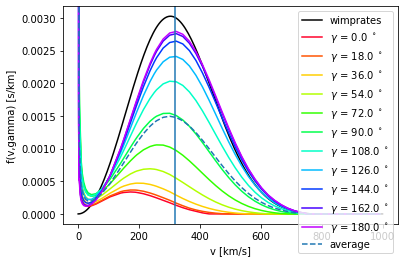

In [4]:
_, x,y  = df.keys()
headers = np.unique(df['gamma/pi'].values)
# for i, header in enumerate(headers):
def get_average(df, headers, projection):
    masks = np.array([df['gamma/pi'] == header for header in headers])
    combined = np.array([df[mask][projection].values for mask in masks])
    return np.average(combined,axis = 0)
df_average = pd.DataFrame()
for projection in [x,y]:
    df_average[projection] = get_average(df, headers, projection)
df_average.head(5)
cm = plt.get_cmap('gist_rainbow')
headers = np.unique(df['gamma/pi'].values)
n_headers = len(headers)
wr_x = np.linspace(0,1000,200) * nu.km / nu.s
wr_y2 = wr.observed_speed_dist(wr_x, 0) * nu.km /nu.s 
plt.plot(wr_x/(nu.km / nu.s),wr_y2, c = 'black', label = "wimprates")
# plt.axvline(310)
plt.xlabel("v [km/s]")
# plt.ylabel("$f (v)$")
wr_lim = plt.ylim()
for i, header in enumerate(headers):
    mask = df['gamma/pi'] == header
    kwargs = {'color': cm(float(i)/n_headers),
        'label': '$\gamma$ = %.1f $^\circ$'%np.rad2deg(header*np.pi)}
    plt.plot(df[mask][x], df[mask][y], **kwargs)    
    plt.ylabel(y.replace("_"," "))
plt.ylim(*wr_lim)

plt.plot(df_average[x],df_average[y], label = 'average', linestyle = '--')
plt.legend()
plt.axvline(np.sqrt(220**2 + 232**2))

# df_avg = pd.read_csv(files[1])
# plt.plot(df_avg[x],df_avg[y], label = 'average (from verne)', linestyle = '-.')

(1e-07, 10000000000.0)

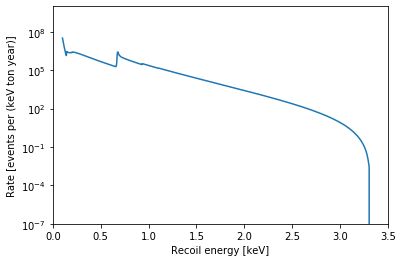

In [5]:
# NR's
energies = np.linspace(0.1, 3.5, 1000)

# dr/dr
dr = ((nu.keV * (1000 * nu.kg) * nu.year) * 
    wr.rate_migdal(energies * nu.keV, 
                    mw=1 * nu.GeV/nu.c0**2, 
                    sigma_nucleon=1e-35 * nu.cm**2))

plt.plot(energies, dr, label="WIMPrates SHM")

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")

plt.xlim(0, energies.max())
plt.yscale("log")

plt.ylim(1e-7,1e10)
# dr

## Detector smearing

# Inference #
Below we setup the inference

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [6]:
use_SHM = dddm.SHM()

In [7]:
def get_gal_spec(det):

    spec_class = dddm.GenSpectrum(1, 1e-35, use_SHM, dddm.experiment[det])
#     spec_class.E_max = 1
#     spec_class.mw = 50
    spec_class.n_bins = 20
    return spec_class.get_data(poisson = False)

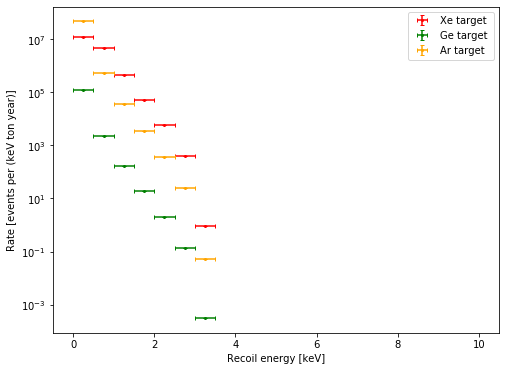

In [8]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
fig,ax=plt.subplots(figsize = (8,6))
dddm.plot_spectrum(get_gal_spec('Xe_migd'), 'red', label = 'Xe target ', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ge_migd'), 'green', label = 'Ge target', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ar_migd'), 'orange', label = 'Ar target', plot_error = False)
plt.yscale("log")
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

In [9]:
def get_det_spec(det, mw =50):
    spec_class = dddm.DetectorSpectrum(1, 1e-35, use_SHM, dddm.experiment[det])
#     spec_class.E_max = 200
#     spec_class.mw = mw
    spec_class.n_bins = 20
    return spec_class.get_data(poisson = False)

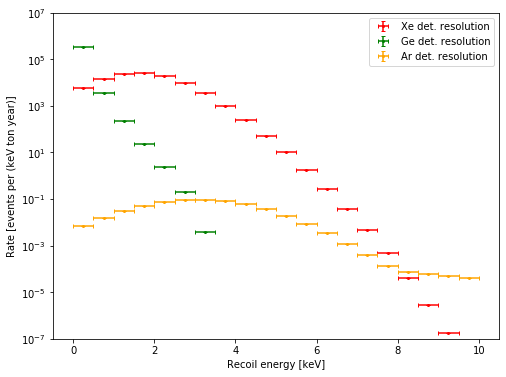

In [10]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
# %%time
fig,ax=plt.subplots(figsize = (8,6))
dddm.plot_spectrum(get_det_spec('Xe_migd'), 'red', label = 'Xe det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ge_migd'), 'green', label = 'Ge det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ar_migd'), 'orange', label = 'Ar det. resolution', plot_error = False)
plt.yscale("log")
plt.ylim(1e-7,1e7)
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

# Likelihood profiling

In [11]:
# dddm.plt_ll_sigma_spec()

In [12]:
# dddm.plt_ll_sigma_det()

In [13]:
# dddm.plt_ll_mass_spec()
# plt.ylim(-1000,0)

In [14]:
# dddm.plt_ll_mass_det()
# plt.ylim(-1000,0)

# Nested sampling

In [15]:
fit_class = dddm.NestleStatModel('Xe_migd')
fit_class.tol = 0.99
fit_class.nlive = 100
fit_class.set_prior('migdal')
fit_class.set_benchmark(mw = 1, sigma = -35)
print(f"Fitting for parameters:\n{fit_class.fit_parameters}")

StatModel::	initialized for Xe_migd detector. See print(stat_model) for default settings
StatModel::	taking log10 of mass of 1
StatModel::	re-evaluate benchmark


/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


Fitting for parameters:
['log_mass', 'log_cross_section']


In [16]:
fit_class.run_nestle()
fit_class.get_summary()

run_nestle::	start_fit for 2 parameters
Value error for v is 133428466.89231493
Nestle did not finish due to a ValueError. Was running with
2 for fit parameters ['log_mass', 'log_cross_section']


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-867d91fe0b96>", line 1, in <module>
    fit_class.run_nestle()
  File "/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/nestle.py", line 119, in run_nestle
    raise e
  File "/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/nestle.py", line 112, in run_nestle
    dlogz=tol)
  File "/home/joran/.conda/envs/DD_DM/lib/python3.7/site-packages/nestle-0.2.0-py3.7.egg/nestle.py", line 865, in sample
    active_logl[i] = loglikelihood(active_v[i, :])
  File "/mnt/c/Users/Joran/Google Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/nestle.py", line 92, in _log_probability_nestle
    return self.log_probability_nestle(t

ValueError: A value in x_new is above the interpolation range.

In [ ]:
fit_class.show_corner()

In [ ]:
assert False

In [ ]:
fit_unconstrained = dddm.NestleStatModel('Xe')
fit_unconstrained.tol = 0.8
fit_unconstrained.nlive = 2000
fit_unconstrained.set_fit_parameters(fit_unconstrained.known_parameters)
print(f"Fitting for parameters:\n{fit_unconstrained.fit_parameters}")

In [ ]:
fit_unconstrained.run_nestle()
fit_unconstrained.get_summary()

In [ ]:
fit_unconstrained.show_corner()

In [ ]:
print(1)